In [1]:
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from functools import reduce
from torch.utils.data.sampler import SubsetRandomSampler

torch.cuda.empty_cache()

In [2]:
# bs=32
# train = MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=True)
# test= MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=False)

In [3]:


bs=32*8*2
train = FashionMNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=True)
test= FashionMNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=False)

In [4]:
def stratified_sampler(labels,classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


In [5]:
classes=[0,1,2,3,4,5]
num_classes=len([0,1,2])
train_loader = torch.utils.data.DataLoader(
  train,
  batch_size=bs,sampler=stratified_sampler(train.targets,classes))

test_loader = torch.utils.data.DataLoader(
  test,
  batch_size=bs,sampler=stratified_sampler(test.targets,classes))

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

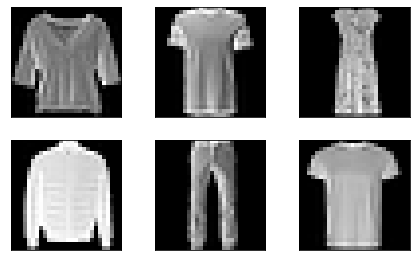

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
# fig

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
torch.cuda.get_device_name()

'GeForce GTX 1060 3GB'

In [10]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [11]:
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [12]:
NNprint_=False
class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input

In [13]:

class VAE(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32,num_labels=0):
        super(VAE, self).__init__()
        self.encoder = torch.nn.Sequential(
            NNprint(),
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            Flatten(),
            
            
            NNprint(),
            
        )
        self.h_dim=h_dim
        self.num_labels=num_labels
        self.fc1 = torch.nn.Linear(h_dim, z_dim)
        self.fc2 = torch.nn.Linear(h_dim, z_dim)
        self.fc3 = torch.nn.Linear(z_dim+num_labels, h_dim)
        
        self.decoder = torch.nn.Sequential(
            NNprint(),
            UnFlatten(),
            NNprint(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4,padding=0, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
            NNprint(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * esp.to(device)
        return z
    
    def bottleneck(self, h,labels):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        if self.num_labels>0:
            z=torch.cat((z,torch.nn.functional.one_hot(labels,self.num_labels).type(torch.float).to(device)),1)
        return z, mu, logvar

    def encode(self, x,labels):
        h = self.encoder(x)
#         h=torch.cat((h,labels.float().reshape(labels.size(0),1).to(device)),dim=1)
        z, mu, logvar = self.bottleneck(h,labels)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x,labels):
        z, mu, logvar = self.encode(x,labels)
#         print('z',z.shape)
        z = self.decode(z)
        return z, mu, logvar
    
    def sample(self,z):
        return self.decode(z)

In [14]:
image_channels = example_data.size(1)
image_channels

1

In [15]:
model = VAE(image_channels=image_channels,h_dim=1024,z_dim=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.to(device), size_average=False,reduction='sum' )
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [17]:
epochs=50

In [29]:
%%time
for epoch in range(epochs):
    for idx, (images, labels) in enumerate(train_loader):
#         print(idx)
        recon_images, mu, logvar = model(images.to(device),labels)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx%500==0:
            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                        epochs, loss.data.cpu().numpy().tolist()/bs, bce.data.cpu().numpy().tolist()/bs, kld.data.cpu().numpy().tolist()/bs)
            print(to_print)
torch.save(model.state_dict(), 'vae.torch')


Epoch[1/100] Loss: 207.384 207.370 0.014
Epoch[2/100] Loss: 203.746 203.733 0.013
Epoch[3/100] Loss: 205.311 205.297 0.014
Epoch[4/100] Loss: 205.361 205.347 0.013
Epoch[5/100] Loss: 209.692 209.679 0.013
Epoch[6/100] Loss: 201.436 201.423 0.013
Epoch[7/100] Loss: 208.229 208.216 0.014
Epoch[8/100] Loss: 209.517 209.503 0.014
Epoch[9/100] Loss: 210.670 210.658 0.013
Epoch[10/100] Loss: 206.777 206.764 0.013
Epoch[11/100] Loss: 211.422 211.408 0.013
Epoch[12/100] Loss: 209.201 209.188 0.013
Epoch[13/100] Loss: 210.768 210.754 0.014
Epoch[14/100] Loss: 205.230 205.216 0.013
Epoch[15/100] Loss: 206.254 206.240 0.014
Epoch[16/100] Loss: 209.358 209.345 0.013
Epoch[17/100] Loss: 205.668 205.654 0.013
Epoch[18/100] Loss: 211.922 211.909 0.013
Epoch[19/100] Loss: 203.878 203.865 0.014
Epoch[20/100] Loss: 208.114 208.101 0.014
Epoch[21/100] Loss: 210.411 210.398 0.013
Epoch[22/100] Loss: 208.750 208.737 0.014
Epoch[23/100] Loss: 215.946 215.933 0.013
Epoch[24/100] Loss: 206.278 206.265 0.013
E

KeyboardInterrupt: 

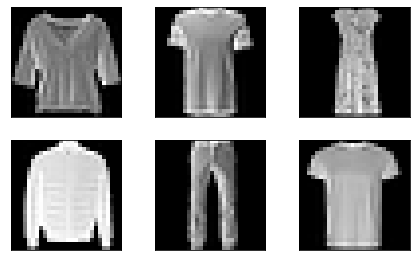

In [30]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

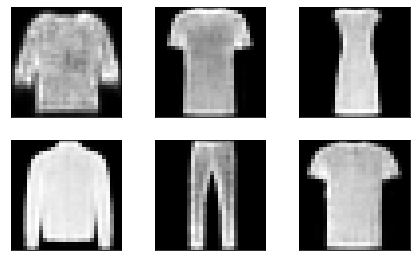

In [31]:
example_data_nn=model(example_data.to(device),example_targets)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data_nn[0][i][0].cpu().data, cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [32]:
def plot_examples(model=None,sample=False,data=None):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            batch_idx, (data, example_targets) = next(examples)
            if sample:
                zeros=torch.zeros(10,1024)
                samples= torch.cat((torch.rand(32,1024),zeros)).T
                data = model.sample(samples.to(device))
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data, cmap='gray', interpolation='none')
        else:
            plt.imshow(data[i][0], cmap='gray', interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

## Visualize outcome on training data

In [33]:
ztest, mutest, logvartest= model.encode(example_data.to(device),example_targets)
test_data=torch.zeros(64,8)
for i in range(test_data.shape[1]):
    print('max',ztest[:,i].max())
    print('min',ztest[:,i].min())
    print('mean',ztest[:,i].mean())
    print()

max tensor(2.8716, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-1.9150, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(0.4307, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(2.3794, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-2.1294, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(-0.1143, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(1.2283, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-3.1452, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(-0.2475, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(2.6974, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-1.5885, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(0.5856, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(2.0266, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-2.4886, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(3.2748, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-1.2939

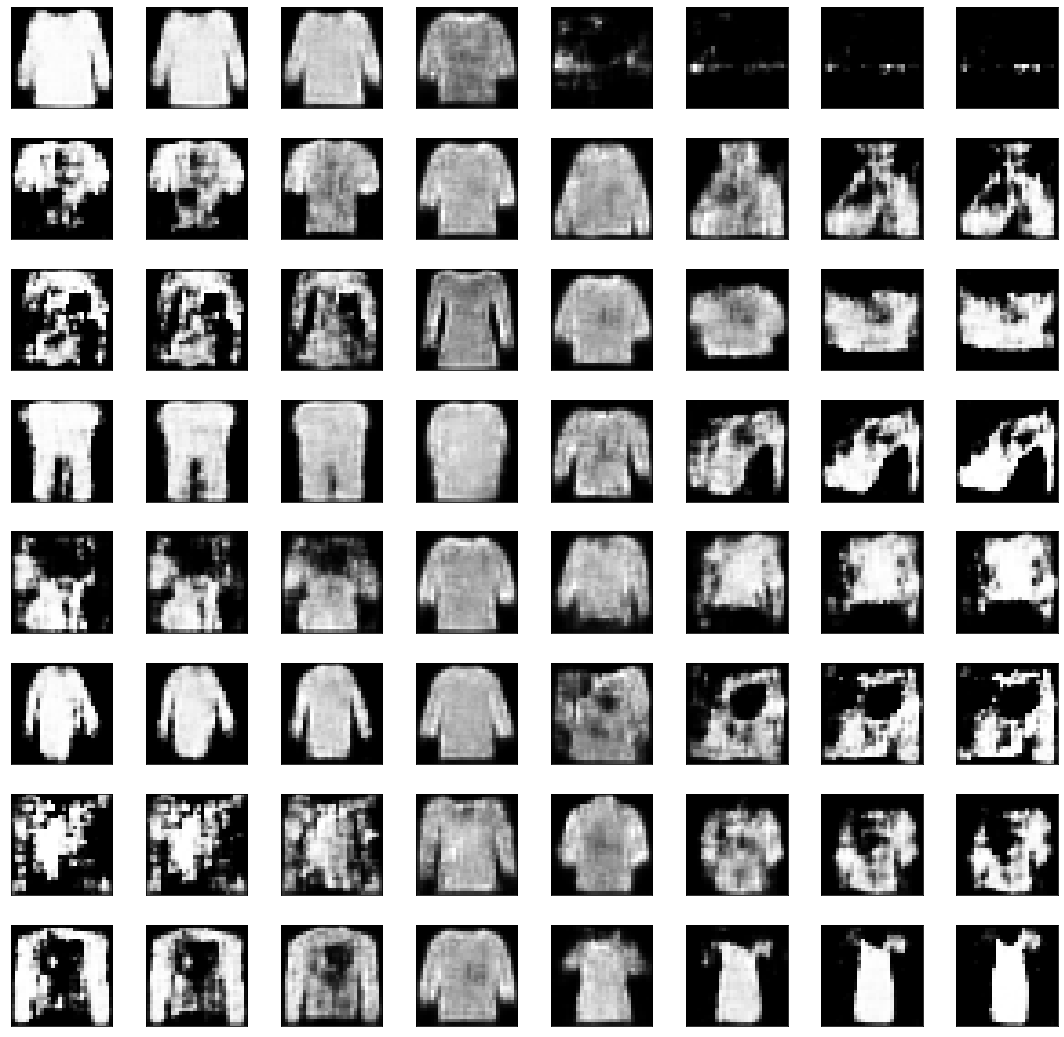

In [43]:

for i in range(test_data.shape[0]):
    test_data[i]=ztest[0]

test_data=torch.zeros(64,8)    
range_=np.linspace(5,-5,8)
for c in range(64):
    test_data[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(test_data.to(device))
plot_examples(model=True,data=smple_pic)

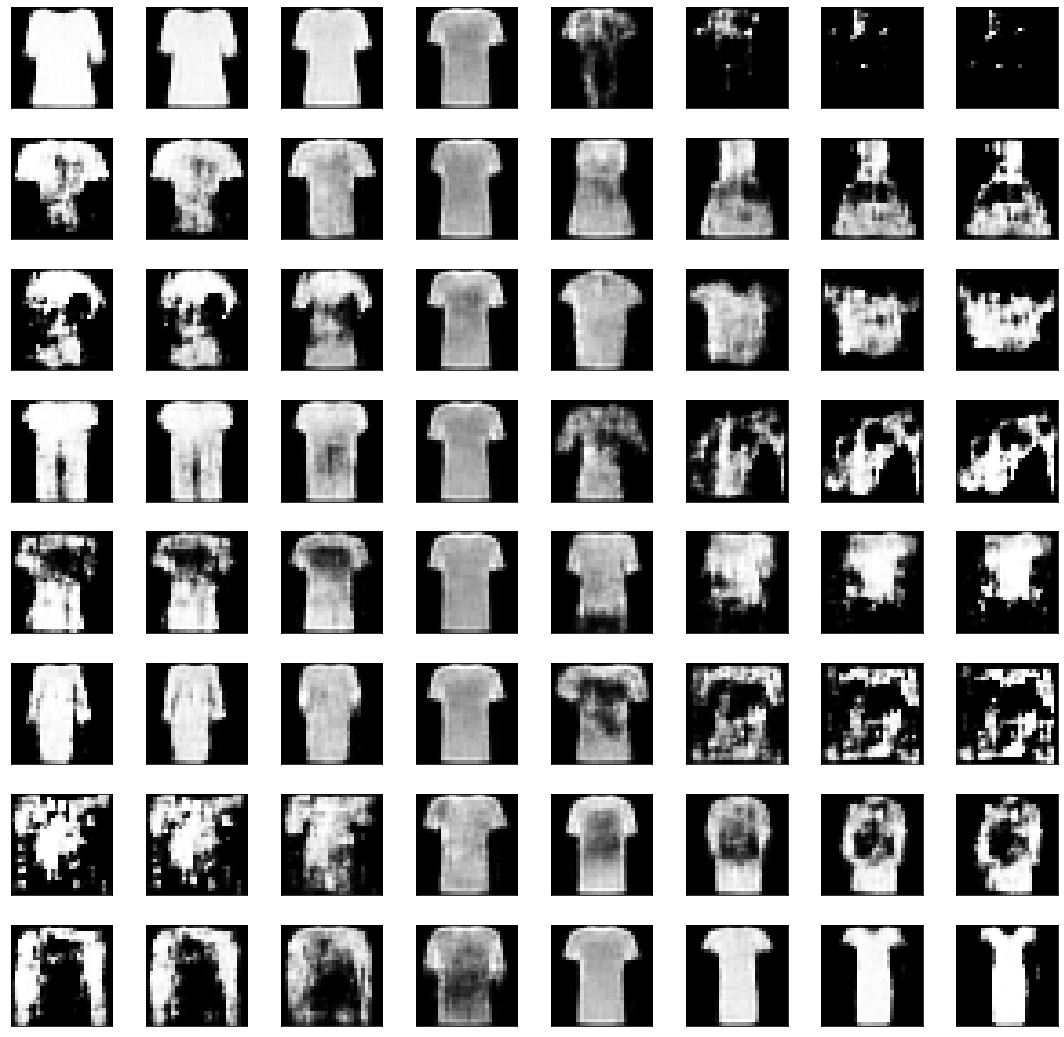

In [42]:
test_data=torch.zeros(64,8)
for i in range(test_data.shape[0]):
    test_data[i]=ztest[1]

    
range_=np.linspace(5,-5,8)
for c in range(64):
    test_data[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(test_data.to(device))
plot_examples(model=True,data=smple_pic)

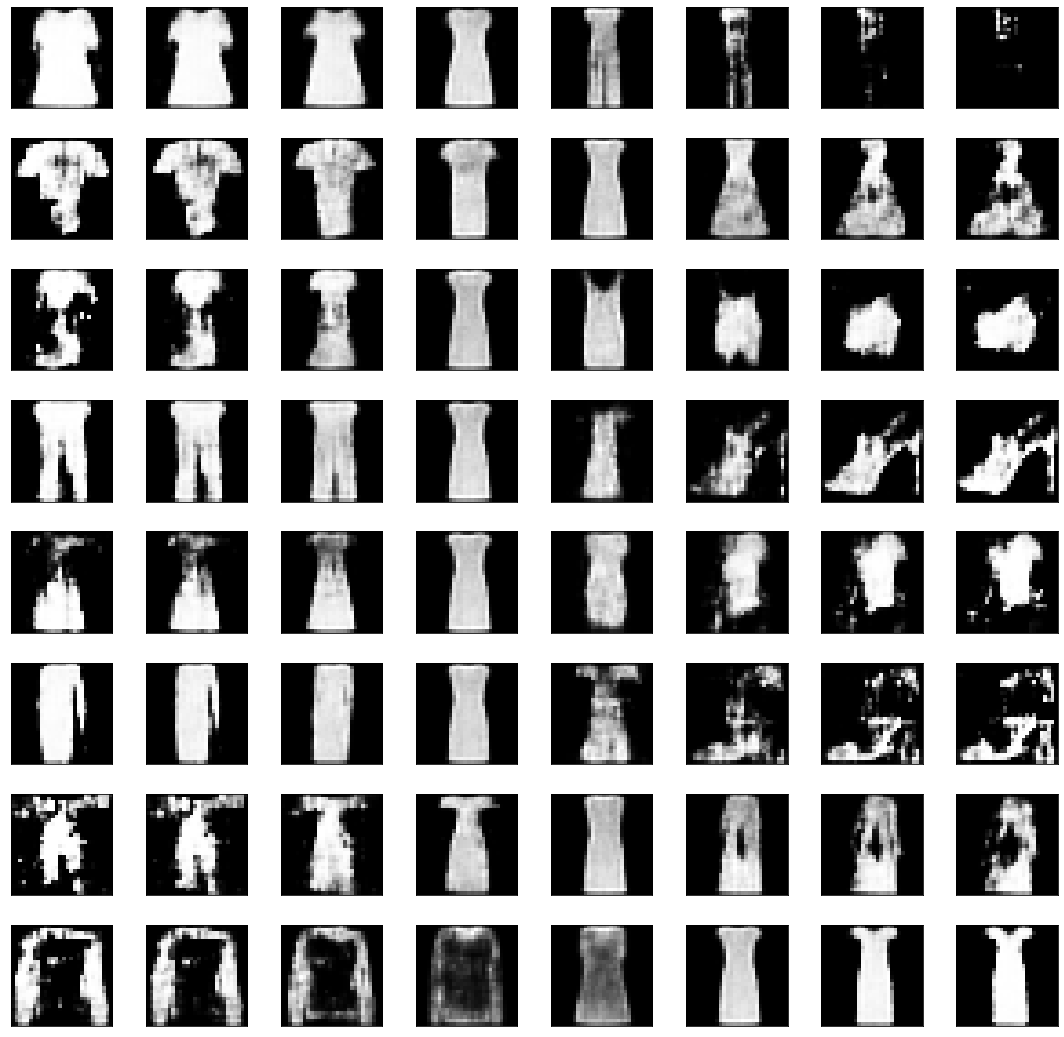

In [41]:
test_data=torch.zeros(64,8)
for i in range(test_data.shape[0]):
    test_data[i]=ztest[2]

    
range_=np.linspace(5,-5,8)
for c in range(64):
    test_data[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(test_data.to(device))
plot_examples(model=True,data=smple_pic)

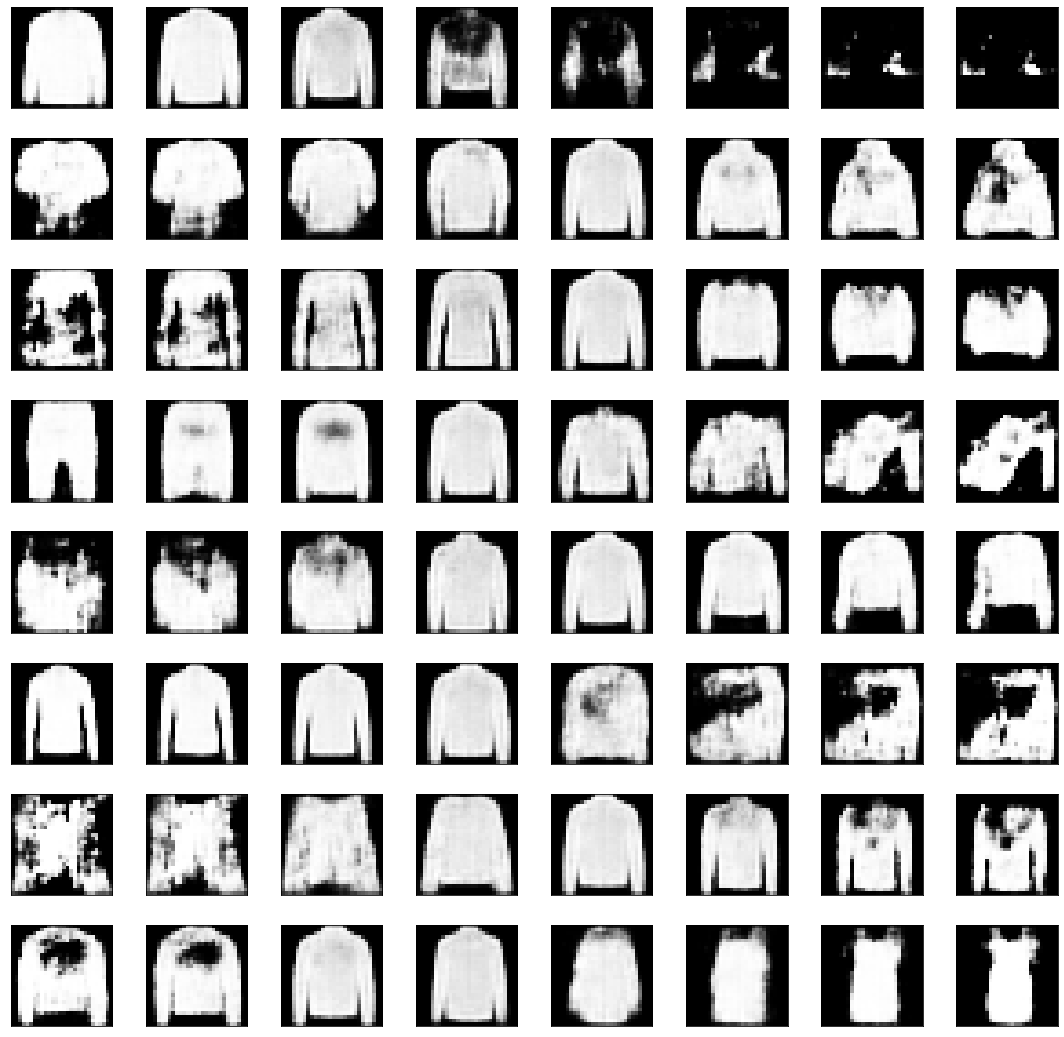

In [40]:
test_data=torch.zeros(64,8)
for i in range(test_data.shape[0]):
    test_data[i]=ztest[3]

    
range_=np.linspace(5,-5,8)
for c in range(64):
    test_data[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(test_data.to(device))
plot_examples(model=True,data=smple_pic)

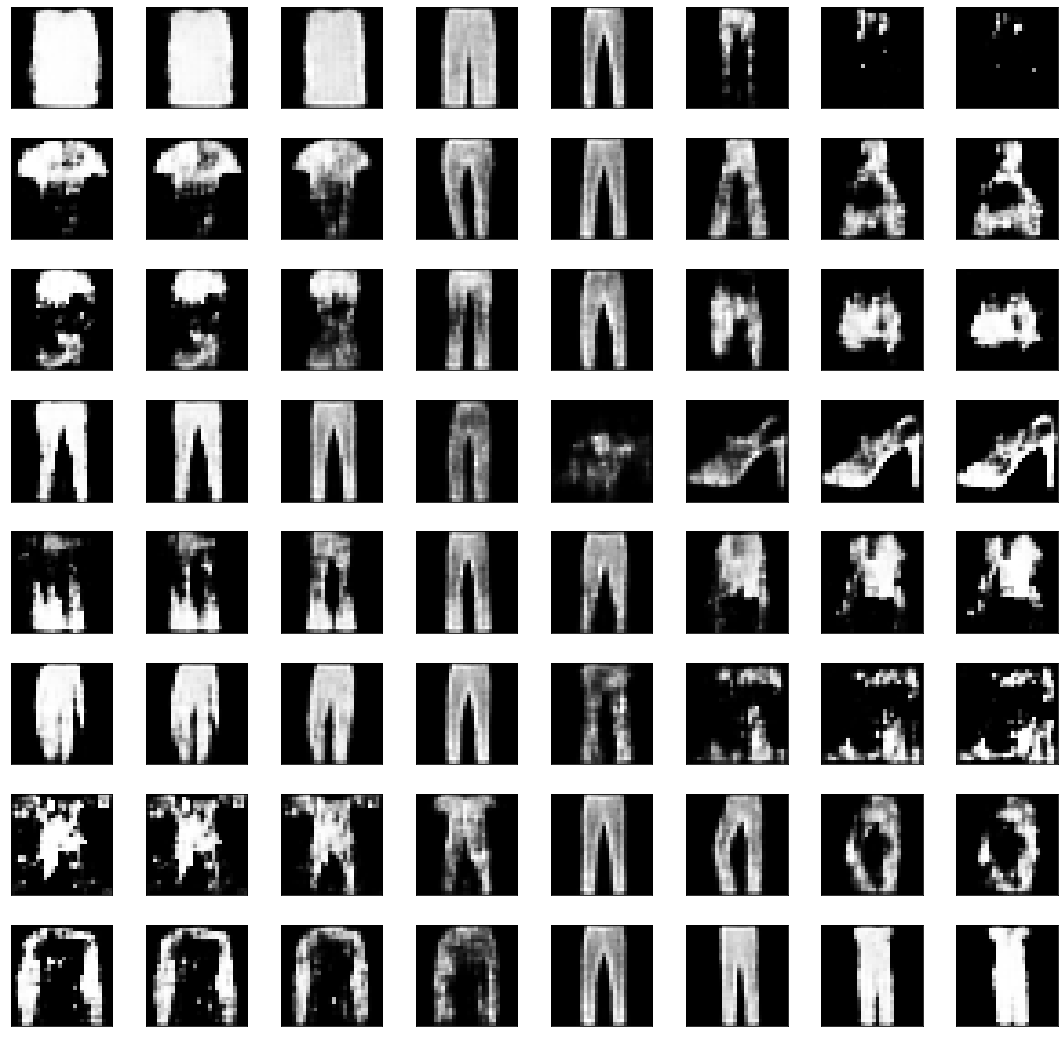

In [44]:
test_data=torch.zeros(64,8)
for i in range(test_data.shape[0]):
    test_data[i]=ztest[4]

    
range_=np.linspace(5,-5,8)
for c in range(64):
    test_data[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(test_data.to(device))
plot_examples(model=True,data=smple_pic)

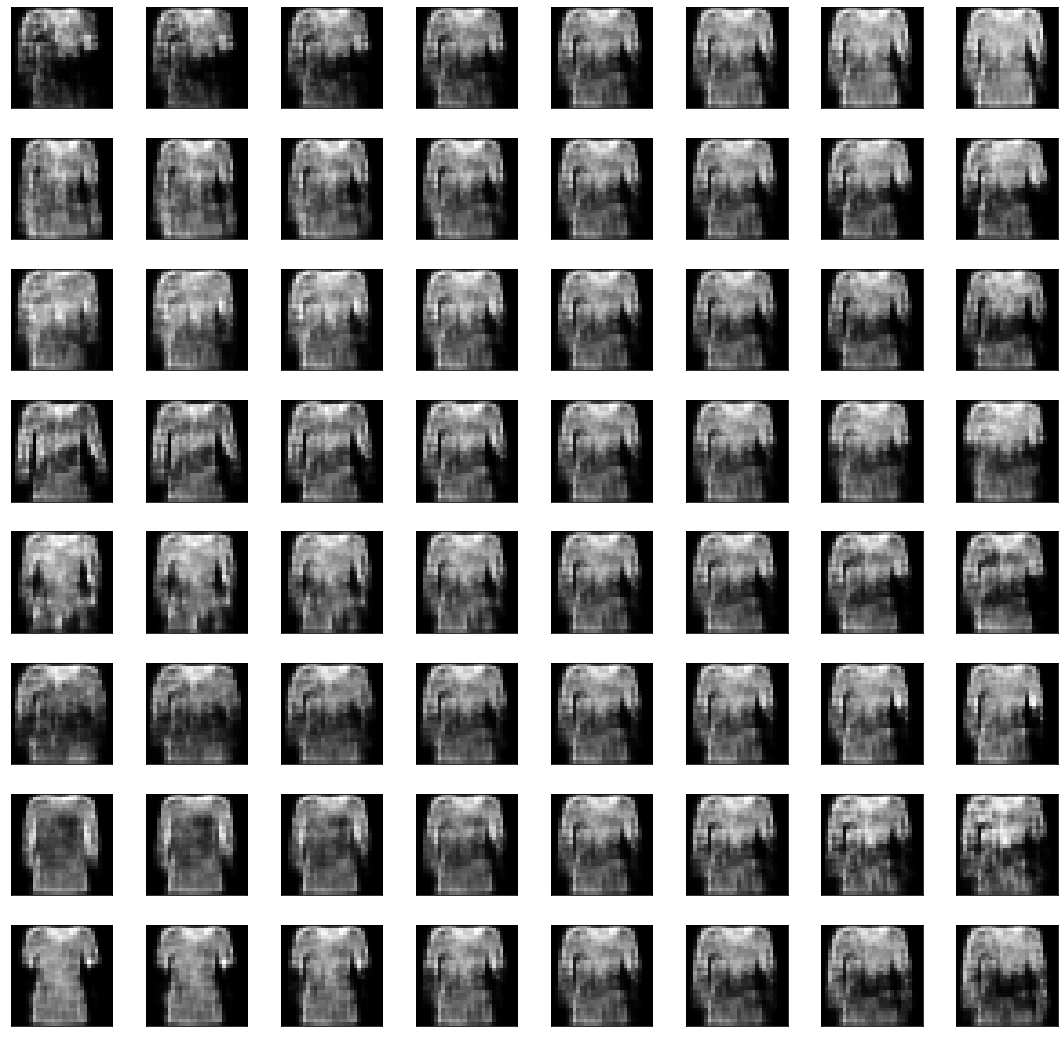

In [39]:
zeros=torch.zeros(10,64)
c=0
for i in zeros:
    
    zeros[c,c]+=1
    c+=1
    if c==10:
        c=0
        
    
range_=np.linspace(0,1,8)
samples=(torch.ones(8,64)*0.6).T
for c in range(64):
    samples[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(samples.to(device))
plot_examples(model=True,data=smple_pic)